In [1]:
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif


import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
data_h = pd.read_json("./data/Copia de churn_historic.json")
data_f = pd.read_json("./data/Copia de churn_future.json")

In [3]:
data_h.shape

(6000, 21)

In [4]:
data_f.shape

(1000, 21)

In [5]:
data_h.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
data_h.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,5386-THSLQ,Female,1,Yes,No,66,No,No phone service,DSL,No,...,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25,No
4,3192-NQECA,Male,0,Yes,No,68,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.00,7611.85,Yes


In [7]:
data_h.loc[data_h["TotalCharges"]==""]["TotalCharges"].value_counts("")

TotalCharges
    10
Name: count, dtype: int64

In [8]:
data_h["SeniorCitizen"] = data_h["SeniorCitizen"].replace(1,"Yes")
data_h["SeniorCitizen"] = data_h["SeniorCitizen"].replace(0,"No")
data_h["TotalCharges"] = data_h["TotalCharges"].replace("",0)

In [9]:
data_h.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

REVISION DE RELACION CON LA VARIABLE OBJETIVO

In [10]:
cols = data_h.columns
features = list(filter(lambda x: x not in ["customerID","Churn"], cols))
numerical_features = ["tenure","MonthlyCharges","TotalCharges"]
categorical_features = list(filter(lambda x: x not in numerical_features, features))

In [11]:
data_h["Churn"].value_counts(dropna=False, normalize=True)

Churn
No     0.734667
Yes    0.265333
Name: proportion, dtype: float64

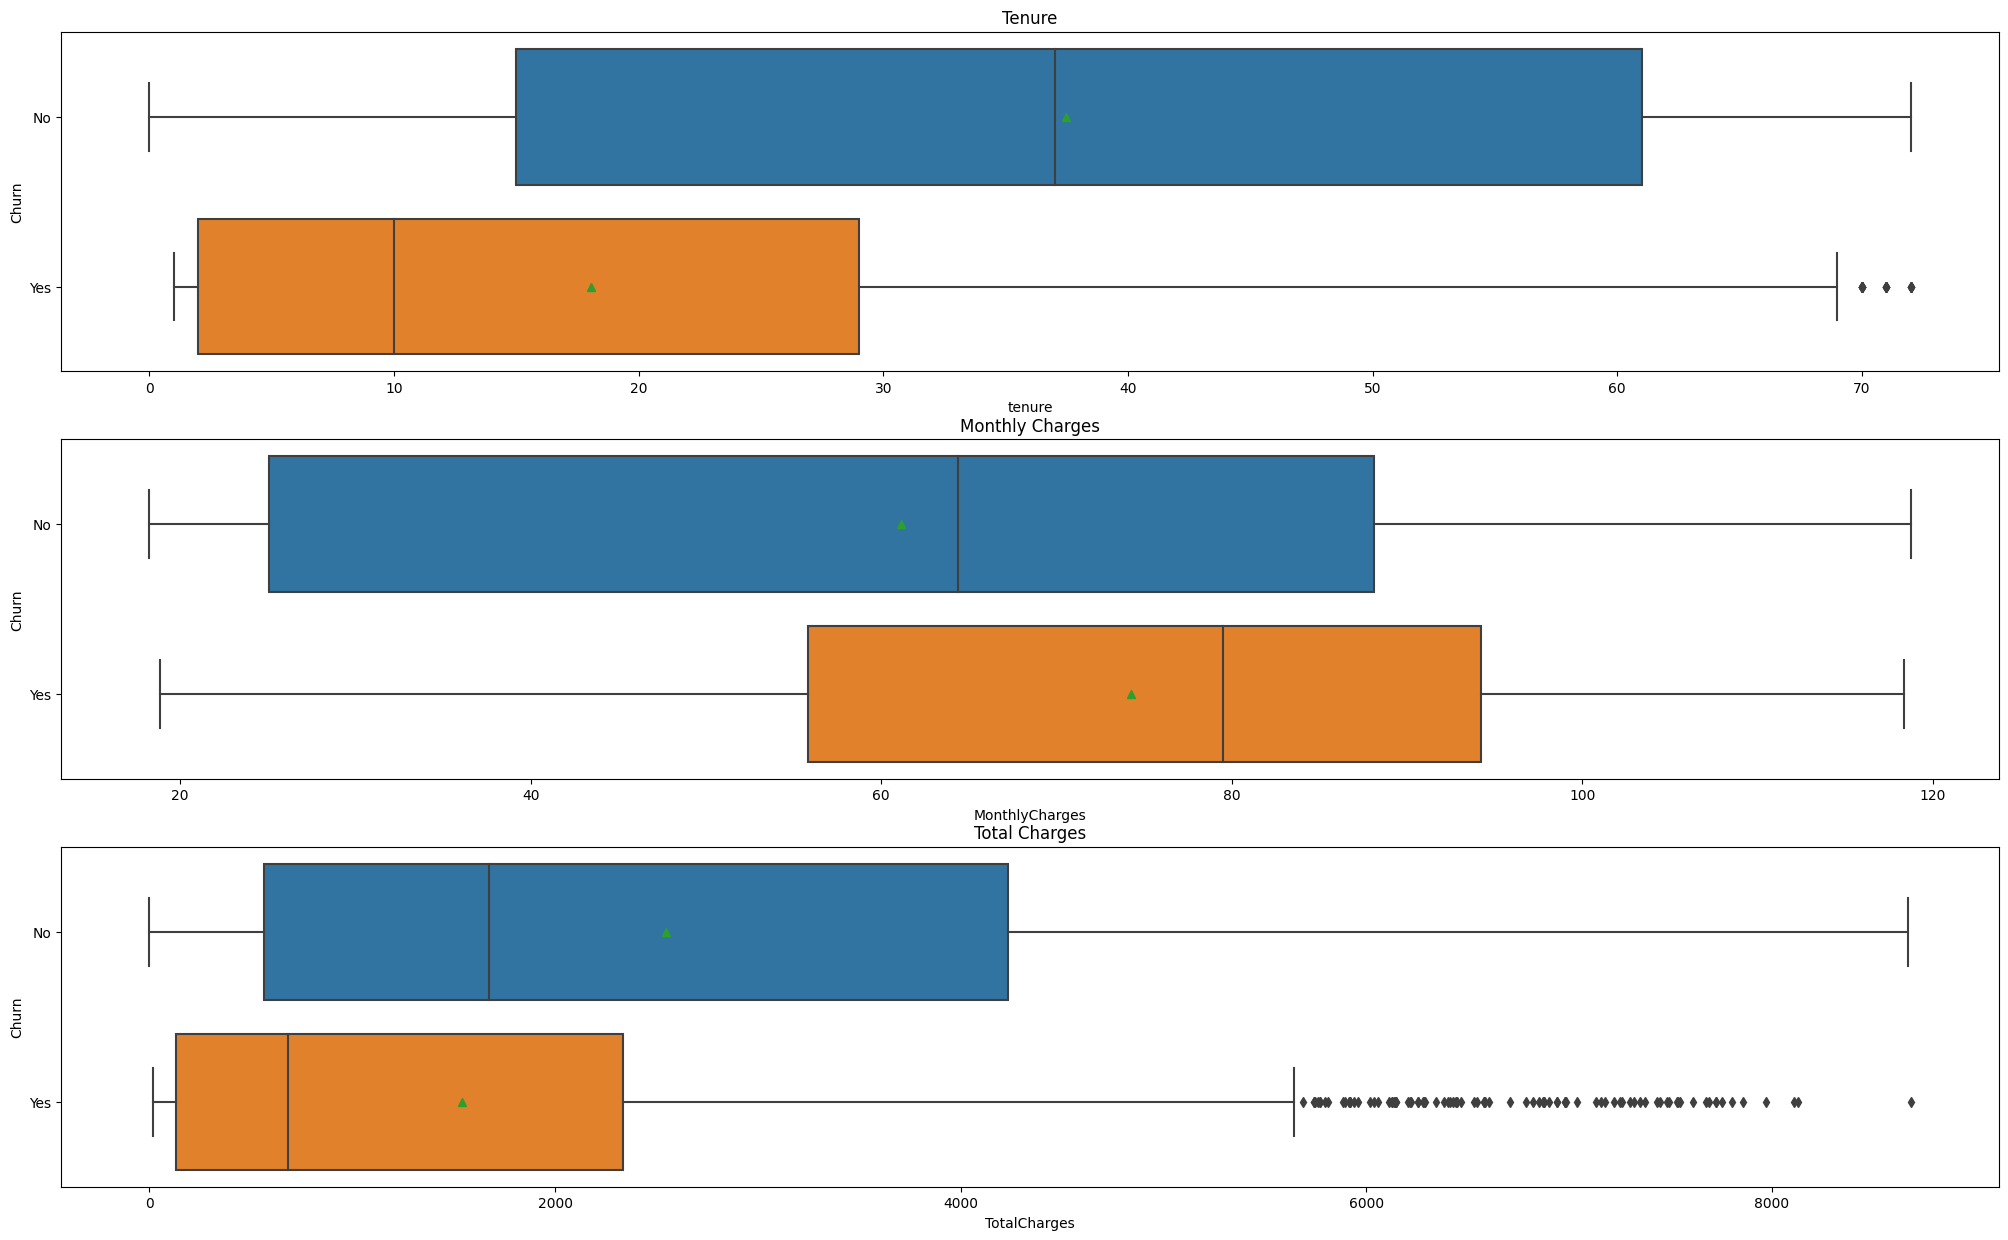

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(25, 15))
sns.boxplot(ax=ax1,data=data_h, x="tenure", y="Churn", showmeans=True, orient="h")
sns.boxplot(ax=ax2,data=data_h, x="MonthlyCharges", y="Churn", showmeans=True, orient="h")
sns.boxplot(ax=ax3,data=data_h, x="TotalCharges", y="Churn", showmeans=True, orient="h")
ax1.set_title("Tenure")
ax2.set_title("Monthly Charges")
ax3.set_title("Total Charges")
plt.show()

In [13]:
pd.crosstab(data_h["Churn"], data_h["gender"], normalize="columns")

gender,Female,Male
Churn,,
No,0.730261,0.738931
Yes,0.269739,0.261069


In [14]:
pd.crosstab(data_h["Churn"], data_h["SeniorCitizen"], normalize="columns")

SeniorCitizen,No,Yes
Churn,,
No,0.763842,0.581686
Yes,0.236158,0.418314


In [15]:
pd.crosstab(data_h["Churn"], data_h["Partner"], normalize="columns")

Partner,No,Yes
Churn,,
No,0.667743,0.806063
Yes,0.332257,0.193937


In [16]:
pd.crosstab(data_h["Churn"], data_h["Dependents"], normalize="columns")

Dependents,No,Yes
Churn,,
No,0.68465,0.850359
Yes,0.31535,0.149641


In [17]:
pd.crosstab(data_h["Churn"], data_h["PhoneService"], normalize="columns")

PhoneService,No,Yes
Churn,,
No,0.752542,0.732717
Yes,0.247458,0.267283


In [18]:
pd.crosstab(data_h["Churn"], data_h["MultipleLines"], normalize="columns")

MultipleLines,No,No phone service,Yes
Churn,,,
No,0.746792,0.752542,0.71666
Yes,0.253208,0.247458,0.28334


In [19]:
pd.crosstab(data_h["Churn"], data_h["InternetService"], normalize="columns")

InternetService,DSL,Fiber optic,No
Churn,,,
No,0.808831,0.580412,0.926236
Yes,0.191169,0.419588,0.073764


In [20]:
pd.crosstab(data_h["Churn"], data_h["OnlineSecurity"], normalize="columns")

OnlineSecurity,No,No internet service,Yes
Churn,,,
No,0.581113,0.926236,0.852907
Yes,0.418887,0.073764,0.147093


In [21]:
pd.crosstab(data_h["Churn"], data_h["OnlineBackup"], normalize="columns")

OnlineBackup,No,No internet service,Yes
Churn,,,
No,0.599695,0.926236,0.78419
Yes,0.400305,0.073764,0.21581


In [22]:
pd.crosstab(data_h["Churn"], data_h["DeviceProtection"], normalize="columns")

DeviceProtection,No,No internet service,Yes
Churn,,,
No,0.603817,0.926236,0.778692
Yes,0.396183,0.073764,0.221308


In [23]:
pd.crosstab(data_h["Churn"], data_h["TechSupport"], normalize="columns")

TechSupport,No,No internet service,Yes
Churn,,,
No,0.584746,0.926236,0.84438
Yes,0.415254,0.073764,0.15562


In [24]:
pd.crosstab(data_h["Churn"], data_h["StreamingTV"], normalize="columns")

StreamingTV,No,No internet service,Yes
Churn,,,
No,0.661345,0.926236,0.701085
Yes,0.338655,0.073764,0.298915


In [25]:
pd.crosstab(data_h["Churn"], data_h["StreamingMovies"], normalize="columns")

StreamingMovies,No,No internet service,Yes
Churn,,,
No,0.658744,0.926236,0.703306
Yes,0.341256,0.073764,0.296694


In [26]:
pd.crosstab(data_h["Churn"], data_h["Contract"], normalize="columns")

Contract,Month-to-month,One year,Two year
Churn,,,
No,0.574552,0.88141,0.970528
Yes,0.425448,0.11859,0.029472


In [27]:
pd.crosstab(data_h["Churn"], data_h["PaperlessBilling"], normalize="columns")

PaperlessBilling,No,Yes
Churn,,
No,0.836546,0.662393
Yes,0.163454,0.337607


In [28]:
pd.crosstab(data_h["Churn"], data_h["PaymentMethod"], normalize="columns")

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
Churn,,,,
No,0.835659,0.852194,0.545813,0.807386
Yes,0.164341,0.147806,0.454187,0.192614


FEATURE RELATIONSHIP

In [29]:
ks_results = []
for f in numerical_features:
    ks_stat, p_value = ks_2samp(data_h.loc[data_h["Churn"] == 'Yes', f], data_h.loc[data_h["Churn"] == "No", f])
    ks_results.append({
        "Feature": f,
        "KS stat": ks_stat,
        "p-value": p_value
    })
pd.DataFrame(ks_results)

,Feature,KS stat,p-value
0,tenure,0.352330,1.348587e-129
1,MonthlyCharges,0.248452,6.368070e-64
2,TotalCharges,0.221103,1.333608e-50


In [30]:
chi2_results = []
for f in categorical_features:
    onehot = OneHotEncoder(sparse=False)
    t = onehot.fit_transform(data_h[[f]])
    values = onehot.categories_[0]
    chi2_stats, p_values = chi2(t, data_h["Churn"])
    
    for value, chi_stat, p_value in zip(values, chi2_stats, p_values):
        chi2_results.append({
            "Feature": f,
            "Value": value,
            "Chi2 stat": chi_stat,
            "p-value": p_value
        })
pd.DataFrame(chi2_results).sort_values(by="Chi2 stat")

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

,Feature,Value,Chi2 stat,p-value
9,PhoneService,Yes,0.105475,7.453554e-01
1,gender,Male,0.284404,5.938289e-01
0,gender,Female,0.293849,5.877644e-01
11,MultipleLines,No phone service,0.967155,3.253906e-01
8,PhoneService,No,0.967155,3.253906e-01
10,MultipleLines,No,2.174286,1.403346e-01
12,MultipleLines,Yes,4.203261,4.034633e-02
33,StreamingMovies,Yes,11.750437,6.082894e-04
30,StreamingTV,Yes,13.335327,2.604526e-04
24,DeviceProtection,Yes,20.533026,5.861121e-06


Correlation

In [31]:
data_h2 = data_h
encoder = OneHotEncoder(handle_unknown='ignore')
data = data_h2[categorical_features]
encoder.fit(data)
codes = encoder.transform(data).toarray()
feature_names = encoder.get_feature_names_out(categorical_features)
data_h2 = pd.concat([data_h2.drop(categorical_features,axis=1), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)
data_h2.head()
col = data_h2.columns
VTD = ["customerID","Churn"]
features_Tot = list(filter(lambda x: x not in VTD, col))

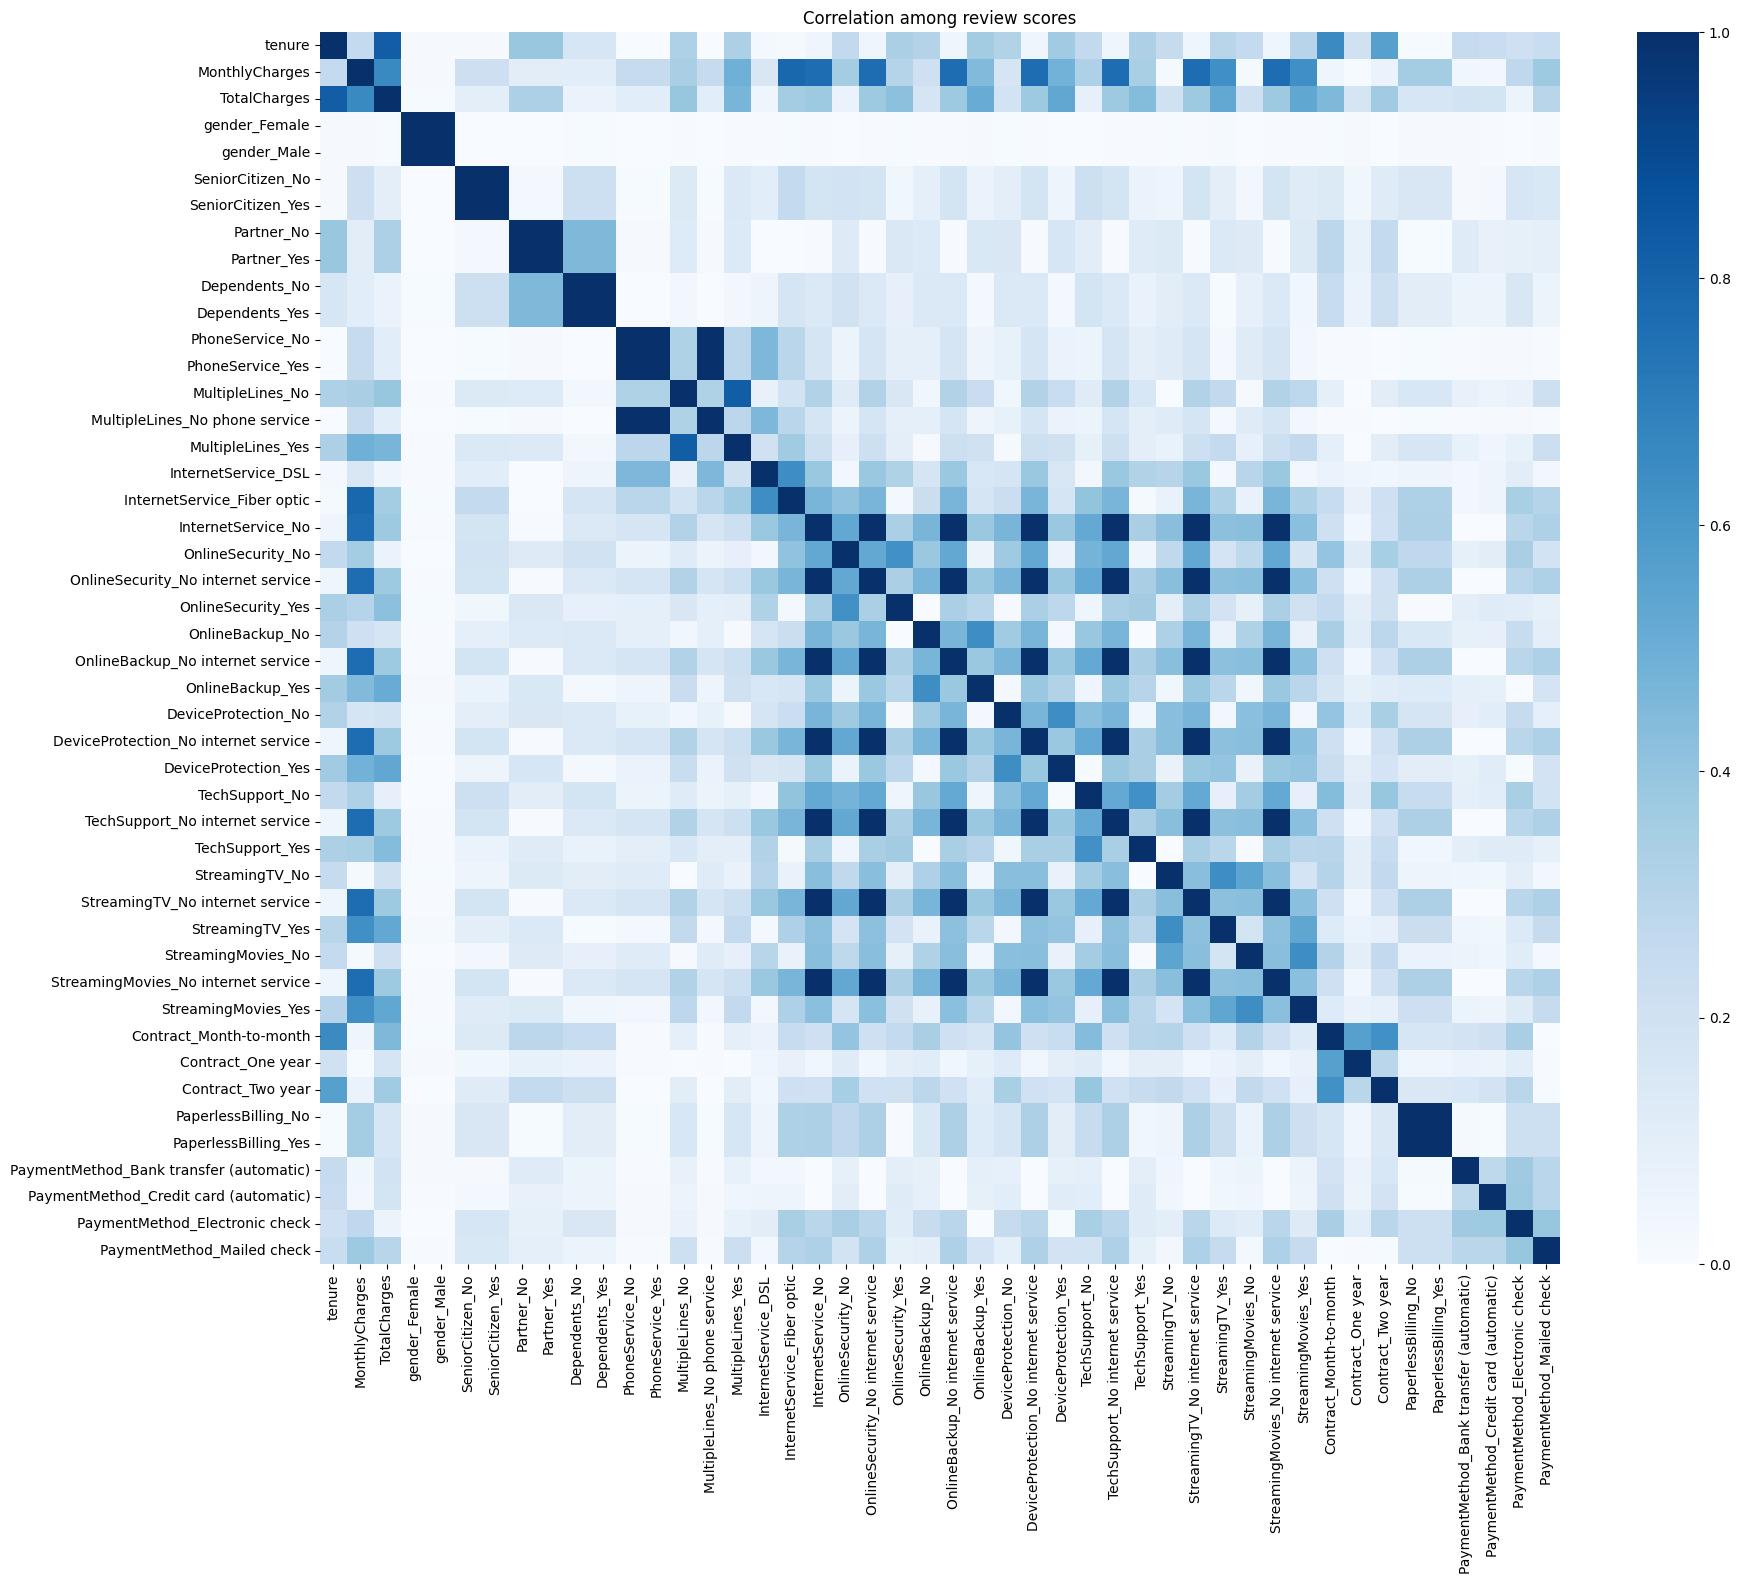

In [32]:
# Plotting correlation heatmap among review scores
plt.figure(figsize=(20, 16))
sns.heatmap(
    #listings_df[["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]].corr(),
    #listings_df[["price_float","maximum_nights","review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]].corr(),
    abs(data_h2[features_Tot].corr()),
    vmin=0, vmax=1,
    cmap="Blues"
)
plt.title("Correlation among review scores")
plt.show()

In [33]:
VTD = ["gender_Female",
       "SeniorCitizen_No",
       "Partner_No",
       "Dependents_No",
       "PhoneService_No",
       "PaperlessBilling_No",
       "OnlineSecurity_No internet service",
       "OnlineBackup_No internet service",
       "DeviceProtection_No internet service",
       "TechSupport_No internet service",
       "StreamingTV_No internet service",
       "StreamingMovies_No internet service",
       "MultipleLines_No phone service"
       ]

In [34]:
col = data_h2.columns
features_Tot_2 = list(filter(lambda x: x not in VTD, features_Tot))

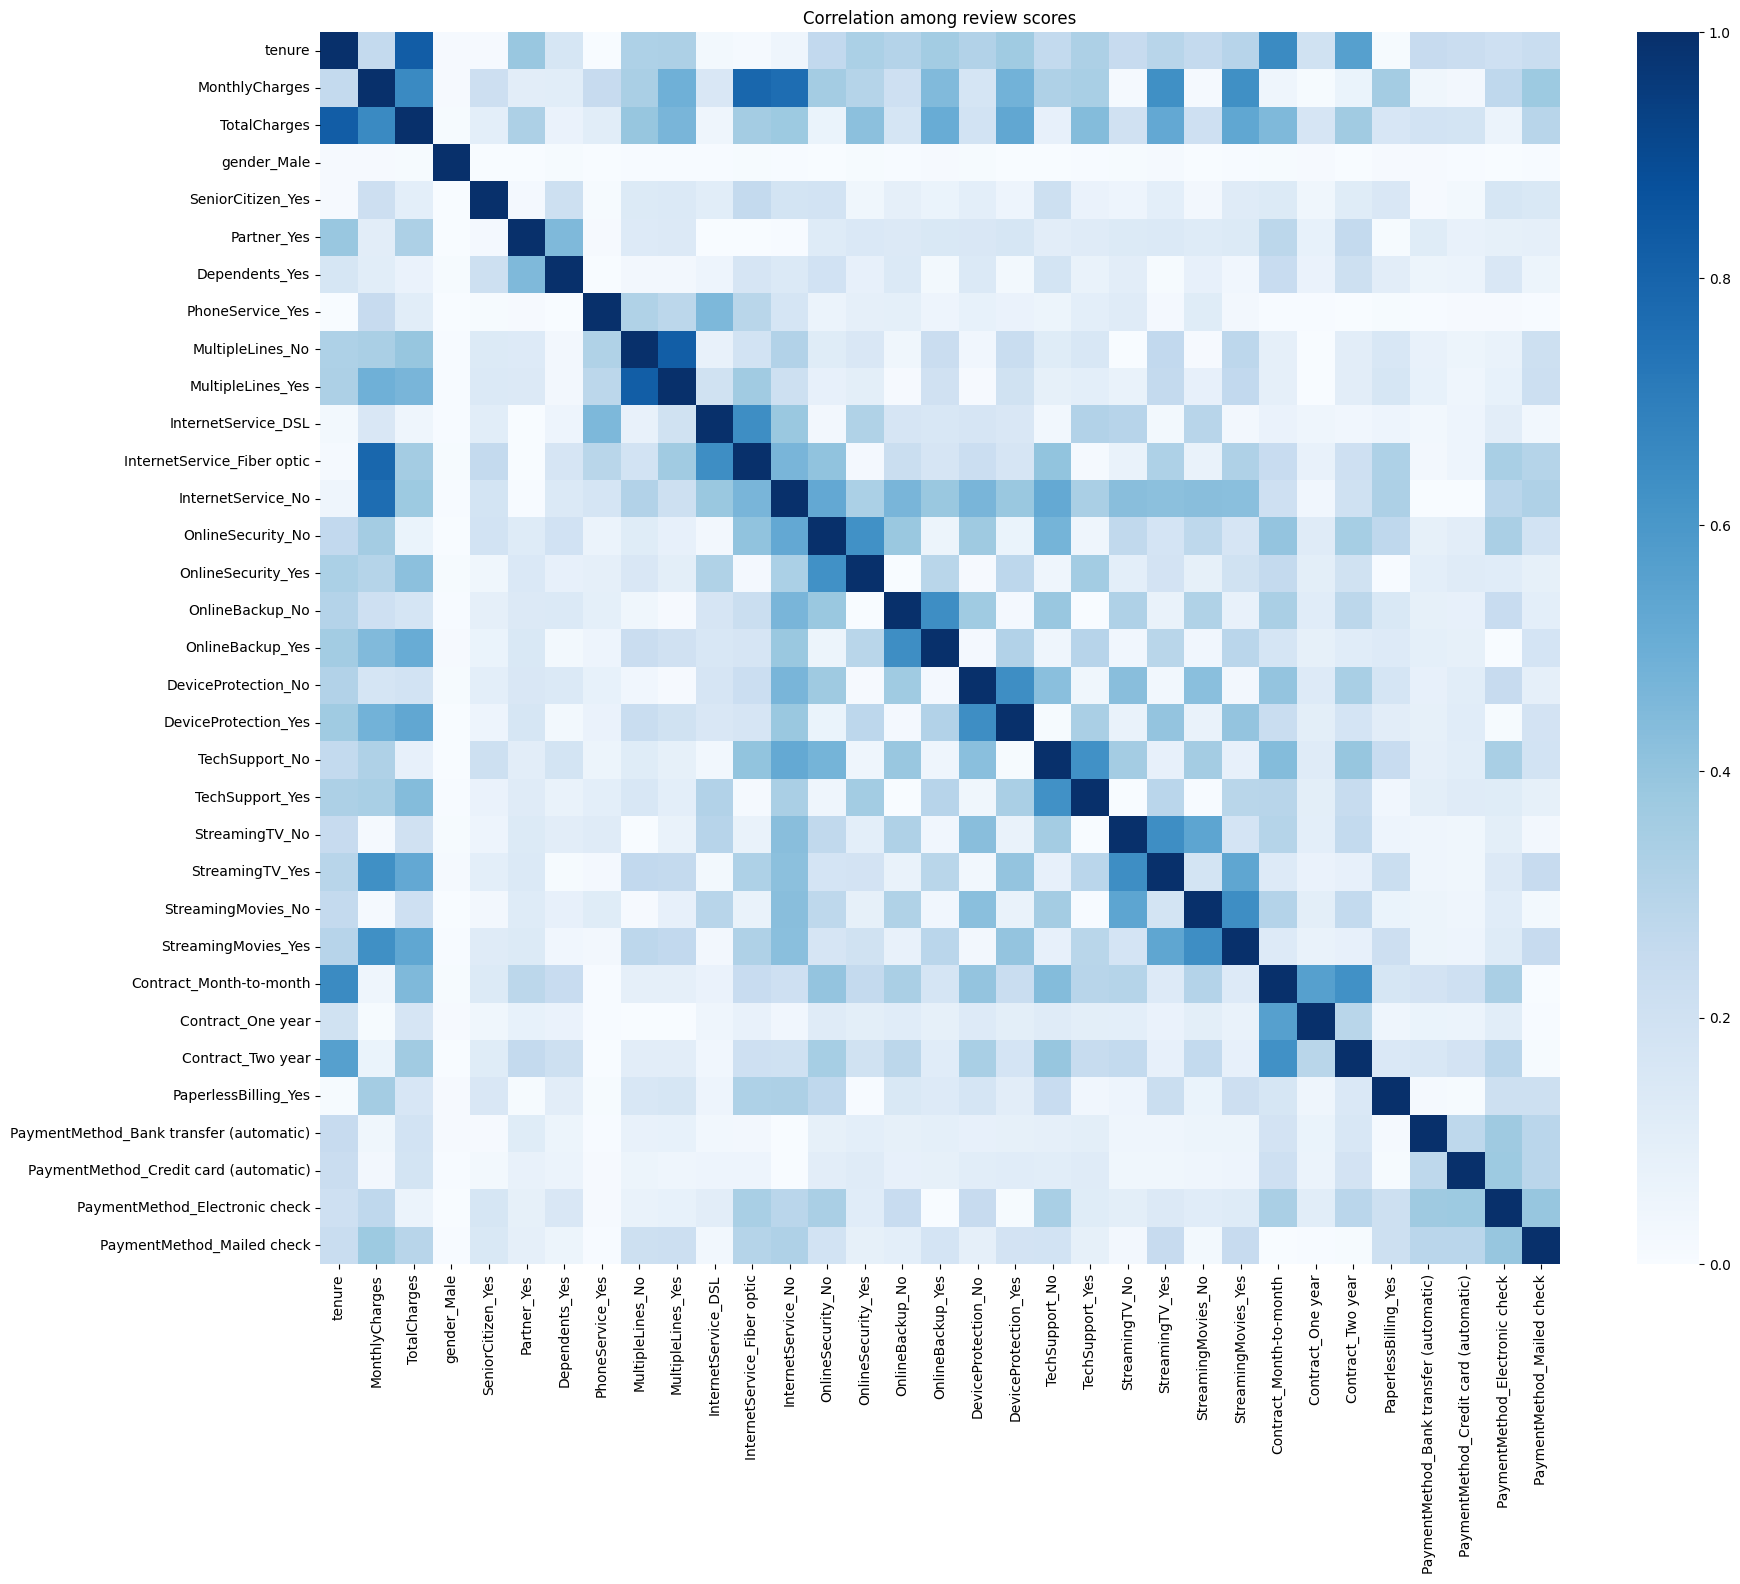

In [35]:
# Plotting correlation heatmap among review scores
plt.figure(figsize=(20, 16))
sns.heatmap(
    #listings_df[["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]].corr(),
    #listings_df[["price_float","maximum_nights","review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]].corr(),
    abs(data_h2[features_Tot_2].corr()),
    vmin=0, vmax=1,
    cmap="Blues"
)
plt.title("Correlation among review scores")
plt.show()

MODELS

In [36]:
data_h["Churn"] = data_h["Churn"].replace("Yes",1)
data_h["Churn"] = data_h["Churn"].replace("No",0)

In [37]:

features = ['gender',
            'SeniorCitizen',
            'Partner',
            'Dependents',
            'tenure',
            'PhoneService',
            'MultipleLines',
            'InternetService',
            'Contract',
            'PaperlessBilling',
            'PaymentMethod',
            'MonthlyCharges',
            'TotalCharges',
]

'''
features = ['gender',
            'SeniorCitizen',
            'Partner',
            'Dependents',
            'tenure',
            'PhoneService',
            'MultipleLines',
            'InternetService',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'Contract',
            'PaperlessBilling',
            'PaymentMethod',
            'MonthlyCharges',
            'TotalCharges'
            ]
'''
numerical_features = ["tenure","MonthlyCharges","TotalCharges"]
categorical_features = list(filter(lambda x: x not in numerical_features, features))

In [38]:
len(features)

13

In [39]:
f1_scorer = make_scorer(f1_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
roc_auc_scorer = make_scorer(roc_auc_score)

feature_selector = SelectKBest(score_func=f_classif)
Feature_vector = list(range(3,20))

BASELINE: REGRESION LOGISITCA

In [40]:
class_model = LogisticRegression()

In [41]:
pipeline_Baseline = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(sparse=False), categorical_features)
    ], remainder="passthrough")),
    ("classifier",  class_model)
])

In [42]:
pipeline_Baseline

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', LogisticRegression())])

In [43]:
pipeline_Baseline.fit(data_h[features],data_h["Churn"])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', LogisticRegression())])

In [44]:
cross_val_results = cross_val_score(pipeline_Baseline, data_h[features], data_h["Churn"], cv=5, scoring='f1')

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_o

In [45]:
print("Cross-Validation F1 for baseline model:", cross_val_results)
print("Mean Cross-Validation F1 for baseline model:", cross_val_results.mean())

Cross-Validation F1 for baseline model: [0.58885017 0.56890459 0.55384615 0.60544218 0.58232236]
Mean Cross-Validation F1 for baseline model: 0.5798730911183141


In [46]:
dump(pipeline_Baseline, "./churn-baseline-v1.0.joblib")


['./churn-baseline-v1.0.joblib']

MODELO 1: RANDOM FOREST

In [241]:
class_model = RandomForestClassifier(random_state=10)

In [242]:
pipeline_Random_Forest = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(sparse=False), categorical_features)
    ], remainder="passthrough")),
    ('feature_selector', feature_selector),
    ("classifier",  class_model)
])

In [243]:
param_grid = {
    'feature_selector__k': Feature_vector,
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth" : [3, 4, 5, 6],
    "classifier__class_weight": ["balanced", None]
}

In [244]:
grid_RF = GridSearchCV(estimator=pipeline_Random_Forest, param_grid=param_grid, scoring=f1_scorer, cv=5, return_train_score=True)

In [245]:
grid_RF

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [50, 100, 150],
                         'feature_selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                 12, 13, 14, 15, 16, 17, 18,
                                                 19]},
             return_train_score=True, scoring=make_scorer(f1_score))

In [246]:
grid_RF.fit(data_h[features],data_h["Churn"])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [50, 100, 150],
                         'feature_selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                 12, 13, 14, 15, 16, 17, 18,
                                                 19]},
             return_train_score=True, scoring=make_scorer(f1_score))

In [247]:
print("Best Parameters:", grid_RF.best_params_)

Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 6, 'classifier__n_estimators': 50, 'feature_selector__k': 7}


In [248]:
cross_val_results = cross_val_score(grid_RF.best_estimator_, data_h[features], data_h["Churn"], cv=5, scoring=f1_scorer)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [249]:
print("Cross-Validation F1 for Random Forrest:", cross_val_results)
print("Mean Cross-Validation F1 for Random Forrest:", cross_val_results.mean())

Cross-Validation F1 for Random Forrest: [0.63840399 0.6328125  0.61144945 0.60966543 0.65110246]
Mean Cross-Validation F1 for Random Forrest: 0.6286867667508419


MODELO 2: ARBOL DE DECISIÓN

In [250]:
class_model = DecisionTreeClassifier()

In [251]:
pipeline_Decision_Tree = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(sparse=False), categorical_features)
    ], remainder="passthrough")),
    ('feature_selector', feature_selector),
    ("classifier",  class_model)
])

In [252]:
# Define the parameter grid for grid search
param_grid = {
    'feature_selector__k':  Feature_vector,
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
}

In [253]:
# Create GridSearchCV object with cross-validation (e.g., 5-fold) using accuracy as the scoring metric
grid_DT = GridSearchCV(pipeline_Decision_Tree, param_grid, cv=5, scoring=f1_scorer)

In [254]:
grid_DT

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 5, 10, 15],
                         'classifier__min_samples_split': [2, 5, 10],
                         'feature_selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                 12, 13, 14, 15, 16, 17, 18,
                                                 19]},
             scoring=make_scorer(f1_score))

In [255]:
# Fit the model to the data
grid_DT.fit(data_h[features], data_h["Churn"])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 5, 10, 15],
                         'classifier__min_samples_split': [2, 5, 10],
                         'feature_selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                 12, 13, 14, 15, 16, 17, 18,
                                                 19]},
             scoring=make_scorer(f1_score))

In [256]:
# Display the best parameters found by the grid search
print("Best Parameters:", grid_DT.best_params_)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'feature_selector__k': 6}


In [257]:
cross_val_results = cross_val_score(grid_DT.best_estimator_, data_h[features], data_h["Churn"], cv=5, scoring=f1_scorer)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [258]:
# Evaluate the model on the test set
print("Cross-Validation F1 for Decision Tree:", cross_val_results)
print("Mean Cross-Validation F1 for Decision Tree:", cross_val_results.mean())

Cross-Validation F1 for Decision Tree: [0.62459547 0.6048     0.58475894 0.60855784 0.5704584 ]
Mean Cross-Validation F1 for Decision Tree: 0.5986341320957129


MODELO 3: GRADIENT BOOSTING

In [259]:
class_model = GradientBoostingClassifier()

In [260]:
pipeline_Gradient_Boosting = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(sparse=False), categorical_features)
    ], remainder="passthrough")),
    ('feature_selector', feature_selector),
    ("classifier",  class_model)
])

In [261]:
# Define the parameter grid for grid search
param_grid = {
    'feature_selector__k':  Feature_vector,  # Number of features to select
    'classifier__n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'classifier__max_depth': [3, 4, 5]  # Maximum depth of the individual trees
}

In [262]:
grid_GB = GridSearchCV(pipeline_Gradient_Boosting, param_grid, cv=5, scoring=f1_scorer)

In [263]:
grid_GB

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [50, 100, 200],
                         'feature_selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                 12, 13, 14, 15, 16, 17, 18,
                                                 19]},
             scoring=make_scorer(f1_score))

In [264]:
# Fit the model to the data
grid_GB.fit(data_h[features], data_h["Churn"])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [50, 100, 200],
                         'feature_selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                 12, 13, 14, 15, 16, 17, 18,
                                                 19]},
             scoring=make_scorer(f1_score))

In [265]:
# Display the best parameters found by the grid search
print("Best Parameters:", grid_GB.best_params_)

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'feature_selector__k': 18}


In [266]:
cross_val_results = cross_val_score(grid_GB.best_estimator_, data_h[features], data_h["Churn"], cv=5, scoring=f1_scorer)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [267]:
# Evaluate the model on the test set
print("Cross-Validation F1 for Decision Tree:", cross_val_results)
print("Mean Cross-Validation F1 for Decision Tree:", cross_val_results.mean())

Cross-Validation F1 for Decision Tree: [0.63683305 0.55595668 0.53287197 0.60929432 0.55673759]
Mean Cross-Validation F1 for Decision Tree: 0.5783387212560953


EXPORTE DEL MODELO

In [268]:
#dump(grid_RF.best_estimator_, "./churn-v1.0.joblib")
#dump(grid_DT.best_estimator_, "./churn-v1.0.joblib")
#dump(grid_GB.best_estimator_, "./churn-v1.0.joblib")

['./churn-v1.0.joblib']